This notebook takes the ~10 min of denoised lidar data, and it reformats the data for use in the Palette inpainting network.

The info in the User Inputs cell should match the values that my inpainting network expects.

Just like `05`, except mash everything into one big cell and iterate over `reconstruction_number`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr

# Basics about data shape

In [2]:
## Configure parameters to match the smallest network in the c&c chain
##   Info in palette_3d/concat_and_cascade/01_create_training_data.ipynb
# Info about the biggest cube of data
nchan_in = 5
ntime_in = 256
nj_in = 64
nk_in = 64

# Info about the position of eventual measurements within the cube
#   These measurement positions will be passed into the DM and mask,
#   but aren't inherently part of the saved output arrays
# "Global" parameters are w.r.t. the full 64x128x64 box,
#   and "Rel" parameters are relative to the trimmed box
## Q3-style Raw measurements at x=3D --> 4-tall, but for denoised 16-wide lidar data
tlo_in_global = 0
thi_in_global = 256
jlo_in_global = 16
jhi_in_global = 48
klo_in_global = 11
khi_in_global = 12

nchan_out = 5
tlo_out_global = 0
thi_out_global = 256
jlo_out_global = 16
jhi_out_global = 48
klo_out_global = 8
khi_out_global = 12

# ## Q4-style Raw measurements at x=3D --> 4-tell
# nchan_out = 5
# tlo_in_global = 0
# thi_in_global = 64
# # jlo_in_global = 22  # 54 = 128/2 - 10; 22 = 64/2 - 10
# # jhi_in_global = 42  # 75 = 128/2 + 11; 43 = 64/2 + 11
# klo_in_global = 11
# khi_in_global = 12

# tlo_out_global = 0
# thi_out_global = 64
# jlo_out_global = 16
# jhi_out_global = 48
# klo_out_global = 9
# khi_out_global = 13

## Misc parameters that become important if we expand width during the 1--> 4 step
if (jlo_in_global != jlo_out_global) or (jhi_in_global != jhi_out_global):
    print("Preparing to expand width of mask for lidar measurements!")
    amr_dy = 10 
    cts_width = (jhi_out_global - jlo_out_global)*amr_dy
    cts_ylo, cts_yhi = jlo_out_global*amr_dy - cts_width, jhi_out_global*amr_dy - cts_width - amr_dy

In [3]:
### Check input values
assert nchan_out <= nchan_in
assert ntime_in >= thi_out_global-tlo_out_global
assert nj_in >= jhi_out_global-jlo_out_global
assert nk_in >= khi_out_global-klo_out_global

assert jlo_in_global <= nj_in
assert jhi_in_global <= nj_in
assert klo_in_global <= nk_in
assert khi_in_global <= nk_in

# Assert that our output is growing and not shrinking
assert jlo_out_global <= jlo_in_global
assert jhi_out_global >= jhi_in_global
assert klo_out_global <= klo_in_global
assert khi_out_global >= khi_in_global

In [4]:
### Calculate relative indices
varlist = ['velocityx', 'velocityy', 'velocityz', 'temperature', 'tke']

# Calculate the relative position of input data to the trimmed box
tlo_in_rel = tlo_in_global - tlo_out_global
thi_in_rel = tlo_in_rel + thi_in_global - tlo_in_global
jlo_in_rel = jlo_in_global - jlo_out_global
jhi_in_rel = jlo_in_rel + jhi_in_global - jlo_in_global
klo_in_rel = klo_in_global - klo_out_global
khi_in_rel = klo_in_rel + khi_in_global - klo_in_global

# Calculate the relative indices of the output box
tlo_out_rel = 0
thi_out_rel = tlo_out_rel + thi_out_global - tlo_out_global
jlo_out_rel = 0
jhi_out_rel = jlo_out_rel + jhi_out_global - jlo_out_global
klo_out_rel = 0
khi_out_rel = klo_out_rel + khi_out_global - klo_out_global

print("Size of input data:")
print(jhi_in_global-jlo_in_global, khi_in_global-klo_in_global)
print("Size of output data:")
print(jhi_out_global-jlo_out_global, khi_out_global-klo_out_global)
print("Indices of relative input data within the trimmed box:")
print("jlo_in_rel, jhi_in_rel, klo_in_rel, khi_in_rel:", jlo_in_rel, jhi_in_rel, klo_in_rel, khi_in_rel)

# outbox = np.zeros((thi_out_rel, jhi_out_rel, khi_out_rel))

Size of input data:
32 1
Size of output data:
32 4
Indices of relative input data within the trimmed box:
jlo_in_rel, jhi_in_rel, klo_in_rel, khi_in_rel: 0 32 3 4


# Read and manipulate data

In [5]:
### User inputs
## Load data
fname = Path(f'/projects/wakedynamics/orybchuk/bcs-ldm/palette/execute_sampling/processed_data/240606/y11520.nc')
parent_out_chunk_dir = Path(fname.parent, fname.stem)
parent_out_chunk_dir.mkdir(exist_ok=True,parents=True)
ds_cts = xr.open_dataset(fname)

In [6]:
ds_cts

<xarray.Dataset>
Dimensions:  (ens: 32, time: 704, y: 32)
Coordinates:
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 696 697 698 699 700 701 702 703
  * y        (y) int64 -160 -150 -140 -130 -120 -110 ... 100 110 120 130 140 150
Data variables:
    u        (ens, time, y) float64 ...
    v        (ens, time, y) float64 ...
    w        (ens, time, y) float64 ...
    T        (ens, time, y) float64 ...
    TKE      (ens, time, y) float64 ...

### Copy, flip, and preprend lidar data
I do this because I have 704 seconds of usable lidar data, but because of chunks sized 128/256, I can only use 640 seconds of it.

In [7]:
### Copy, flip, and prepend lidar data
## Calculate how many timesteps of data we need to prepend
half_chunk = int(thi_in_global/2)
ntime_cts = len(ds_cts['time'])
ntime_chunkable = np.floor(ntime_cts/half_chunk).astype(int) * half_chunk
ntime_leftover = ntime_cts - ntime_chunkable
ntime_prepend = half_chunk - ntime_leftover  # The number of timesteps of data to prepend
ntime_out_cts = ntime_cts + ntime_prepend

## Create a new Dataset to store the lengthened lidar data
time_prepend = np.arange(-1*ntime_prepend, ntime_cts, 1)
coords_prepend = {'ens': ds_cts['ens'],
                  'time': time_prepend,
                  'y': ds_cts['y']}
ds_prepended = xr.Dataset(coords_prepend)

## Prepend data and populate the dataset
u_prepended = np.zeros((len(coords_prepend['ens']),
                      len(coords_prepend['time']),
                      len(coords_prepend['y'])))
u_flipped = ds_cts['u'].isel(time=slice(0,ntime_prepend))[:, ::-1, :]
u_prepended[:,0:ntime_prepend,:] = u_flipped.copy()
u_prepended[:,ntime_prepend:,:] = ds_cts['u'].values.copy()

v_prepended = np.zeros((len(coords_prepend['ens']),
                      len(coords_prepend['time']),
                      len(coords_prepend['y'])))
v_flipped = ds_cts['v'].isel(time=slice(0,ntime_prepend))[:, ::-1, :]
v_prepended[:,0:ntime_prepend,:] = v_flipped.copy()
v_prepended[:,ntime_prepend:,:] = ds_cts['v'].values.copy()

w_prepended = np.zeros((len(coords_prepend['ens']),
                      len(coords_prepend['time']),
                      len(coords_prepend['y'])))
w_flipped = ds_cts['w'].isel(time=slice(0,ntime_prepend))[:, ::-1, :]
w_prepended[:,0:ntime_prepend,:] = w_flipped.copy()
w_prepended[:,ntime_prepend:,:] = ds_cts['w'].values.copy()

T_prepended = np.zeros((len(coords_prepend['ens']),
                      len(coords_prepend['time']),
                      len(coords_prepend['y'])))
T_flipped = ds_cts['T'].isel(time=slice(0,ntime_prepend))[:, ::-1, :]
T_prepended[:,0:ntime_prepend,:] = T_flipped.copy()
T_prepended[:,ntime_prepend:,:] = ds_cts['T'].values.copy()

TKE_prepended = np.zeros((len(coords_prepend['ens']),
                      len(coords_prepend['time']),
                      len(coords_prepend['y'])))
TKE_flipped = ds_cts['TKE'].isel(time=slice(0,ntime_prepend))[:, ::-1, :]
TKE_prepended[:,0:ntime_prepend,:] = TKE_flipped.copy()
TKE_prepended[:,ntime_prepend:,:] = ds_cts['TKE'].values.copy()

ds_prepended['u'] = (('ens', 'time', 'y'), u_prepended)
ds_prepended['v'] = (('ens', 'time', 'y'), v_prepended)
ds_prepended['w'] = (('ens', 'time', 'y'), w_prepended)
ds_prepended['T'] = (('ens', 'time', 'y'), T_prepended)
ds_prepended['TKE'] = (('ens', 'time', 'y'), TKE_prepended)

In [8]:
# ### Trim down the width and time of the continuous measurements
# half_chunk = int(thi_in_global/2)
# ntime_cts = len(ds_cts['time'])
# ntime_out_cts = np.floor(ntime_cts/half_chunk).astype(int) * half_chunk

# ## Trim further to match the expectations of the DM
# ds_cts = ds_cts.isel(time=slice(0,ntime_out_cts))

# if (jlo_in_global != jlo_out_global) or (jhi_in_global != jhi_out_global):
#     raise NotImplementedError
# #     print("Preparing to expand width of mask for lidar measurements!")
# #     y_cts = ds_cts_raw['y'].sel(y=slice(cts_ylo, cts_yhi))
# #     assert len(y_cts) == jhi_out_global - jlo_out_global, "Size mismatch!"
# #     time_cts = ds_cts['time']
    
# #     U_cts_data = np.zeros((len(y_cts), len(time_cts))) * np.nan
# #     U_cts_data[jlo_in_global-jlo_out_global:jhi_in_global-jhi_out_global, :] = ds_cts['U'].data
# #     ds_cts = xr.Dataset(coords={'y':y_cts, 'time':time_cts})
# #     ds_cts['U'] = (('y', 'time'), U_cts_data)

### Iterate over data

0 ...


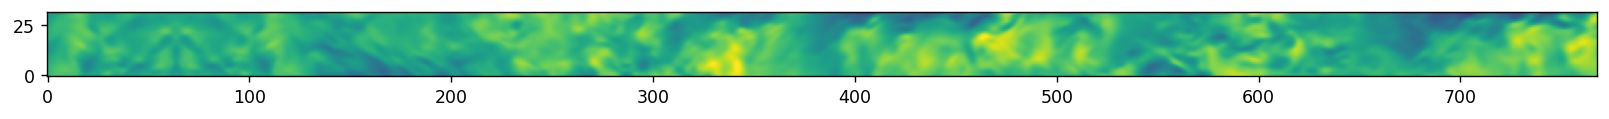

1 ...


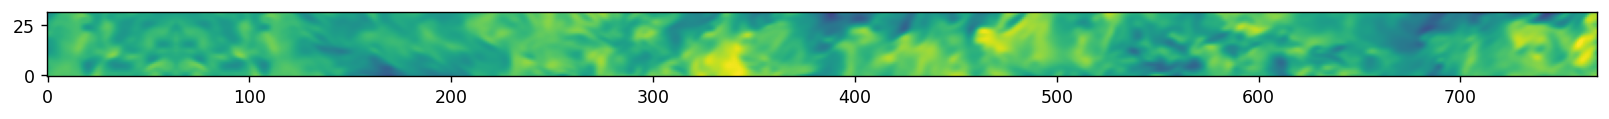

2 ...


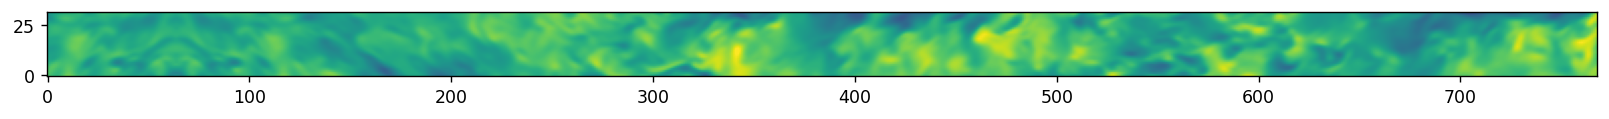

3 ...


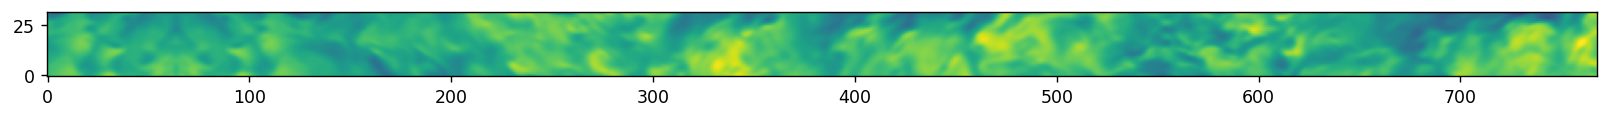

4 ...


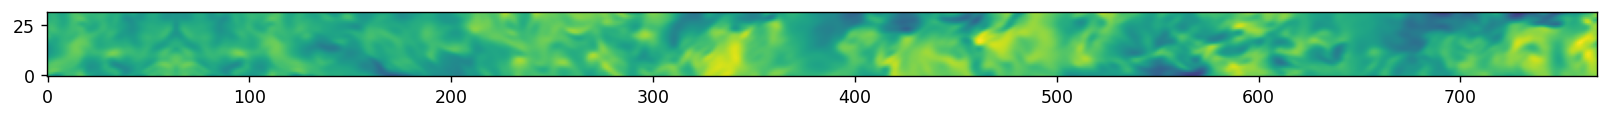

5 ...
6 ...
7 ...
8 ...
9 ...
10 ...
11 ...
12 ...
13 ...
14 ...
15 ...
16 ...
17 ...
18 ...
19 ...
20 ...
21 ...
22 ...
23 ...
24 ...
25 ...
26 ...
27 ...
28 ...
29 ...
30 ...
31 ...


In [9]:
pltmin = 5
pltmax = 12

### ~~~ Visually inspect the continuous measurements ~~~
# fig, ax = plt.subplots(1, 1, figsize=(16,3), dpi=125)

# ax.imshow(ds_cts['noisy_lidar_meas'].values[:,jlo_out_rel:jhi_out_rel].T,
#           origin='lower',
#           vmin=pltmin,
#           vmax=pltmax)
# print("Noisy lidar meas")
# plt.show()

n_ens = len(ds_cts['ens'])

for reconstruction_number in range(0,n_ens):
    print(reconstruction_number, '...')
    reconstruction_id = str(reconstruction_number).zfill(2)
    out_chunk_dir = Path(parent_out_chunk_dir, f'reconstruction{reconstruction_id}')
    out_chunk_dir.mkdir(exist_ok=True, parents=True)
    
    ### Put measurements into height-aware numpy array
    data_arr_cts = np.zeros((nchan_out, ntime_out_cts, jhi_out_rel, khi_out_rel))
    data_arr_cts[0,:,jlo_out_rel:jhi_out_rel,klo_in_rel] = ds_prepended['u'].isel(ens=reconstruction_number).values  # ASSUME: Lidar measurement has a pixel height of 1
    data_arr_cts[1,:,jlo_out_rel:jhi_out_rel,klo_in_rel] = ds_prepended['v'].isel(ens=reconstruction_number).values
    data_arr_cts[2,:,jlo_out_rel:jhi_out_rel,klo_in_rel] = ds_prepended['w'].isel(ens=reconstruction_number).values
    data_arr_cts[3,:,jlo_out_rel:jhi_out_rel,klo_in_rel] = ds_prepended['T'].isel(ens=reconstruction_number).values
    data_arr_cts[4,:,jlo_out_rel:jhi_out_rel,klo_in_rel] = ds_prepended['TKE'].isel(ens=reconstruction_number).values
    
    ### ~~~ Visually inspect the continuous measurements ~~~
    if reconstruction_number < 5:
        fig, ax = plt.subplots(1, 1, figsize=(16,3), dpi=125)

        ax.imshow(data_arr_cts[0,:,jlo_out_rel:jhi_out_rel,klo_in_rel].T,
                  origin='lower',
                  vmin=pltmin,
                  vmax=pltmax)
        plt.show()
    
    ### Create the mask
    ### In Palette, 1 means masked, 0 means observed
    mask_arr_cts = np.ones_like(data_arr_cts)  # Hide everything initially
    mask_arr_cts[0,:,:,klo_in_rel] = np.isnan(data_arr_cts[0,:,:,klo_in_rel]).astype(float)

    ## Create a complementary mask for pictures
    nan_mask_arr_cts = mask_arr_cts.copy()
    nan_mask_arr_cts[nan_mask_arr_cts == 1.0] = np.nan
    nan_mask_arr_cts += 1
    
    ### Partition data and mask into small chunks that can be fed into the DM
    out_twindow = thi_out_global
    out_slide = int(out_twindow/2)

    # Save out first chunk of data
    chunk_counter = 0
    curr_tend = out_twindow
    data_chunk = data_arr_cts[:,0:out_twindow,:,:]
    mask_chunk = mask_arr_cts[:,0:out_twindow,:,:]

    # Reshape mask to match Palette's expectations
    mask_out_shape = (mask_chunk.shape[1:] + (mask_chunk.shape[0],))
    mask_chunk_reshape = np.zeros((mask_out_shape))
    for ichan in range(nchan_out):
        mask_chunk_reshape[:,:,:,ichan] = mask_chunk[ichan,:,:,:].copy()
    mask_chunk = mask_chunk_reshape.copy()  # Overwrite mask_chunk with reshaped data

    np.save(Path(out_chunk_dir, f'data_chunk{str(chunk_counter).zfill(4)}.npy'), data_chunk)
    np.save(Path(out_chunk_dir, f'mask_chunk{str(chunk_counter).zfill(4)}.npy'), mask_chunk)

    # Save out remaining chunks of data
    curr_tend += out_slide
    chunk_counter += 1
    while curr_tend <= data_arr_cts.shape[1]:
        curr_tstart = curr_tend - out_twindow
        data_chunk = data_arr_cts[:,curr_tstart:curr_tend,:,:]
        mask_chunk = mask_arr_cts[:,curr_tstart:curr_tend,:,:].copy()
        mask_chunk[:,0:out_slide,:,:] = 0.0  # For chunks 1 and beyond, show all data in first half

        # Reshape mask to match Palette's expectations
        mask_chunk_reshape = np.zeros((mask_out_shape))
        for ichan in range(nchan_out):
            mask_chunk_reshape[:,:,:,ichan] = mask_chunk[ichan,:,:,:].copy()
        mask_chunk = mask_chunk_reshape.copy()  # Overwrite mask_chunk with reshaped data

        np.save(Path(out_chunk_dir, f'data_chunk{str(chunk_counter).zfill(4)}.npy'), data_chunk)
        np.save(Path(out_chunk_dir, f'mask_chunk{str(chunk_counter).zfill(4)}.npy'), mask_chunk)

        curr_tend += out_slide
        chunk_counter += 1

#     ### Top-down view: Visualize chunked data
#     fig, ax = plt.subplots(1, 3, figsize=(12,3.5), sharex=True, sharey=True, dpi=125)

#     ## Load data
#     viz_data0 = np.load(Path(out_chunk_dir, 'data_chunk0000.npy'))
#     viz_data1 = np.load(Path(out_chunk_dir, 'data_chunk0001.npy'))
#     viz_data2 = np.load(Path(out_chunk_dir, 'data_chunk0002.npy'))

#     ## Decorate
#     ax[0].set_ylabel('y index')
#     ax[0].set_xlabel('Time index')
#     ax[1].set_xlabel('Time index')
#     ax[2].set_xlabel('Time index')
#     ax[0].set_title("Data, t=[0,64]")
#     ax[1].set_title("Data, t=[32,96]")
#     ax[2].set_title("Data, t=[64,128]")

#     ## Plot
#     ichan = 0
#     ax[0].imshow(viz_data0[ichan,:,:,klo_in_rel].T,
#                  origin='lower',
#                  vmin=pltmin,
#                  vmax=pltmax)
#     ax[1].imshow(viz_data1[ichan,:,:,klo_in_rel].T,
#                  origin='lower',
#                  vmin=pltmin,
#                  vmax=pltmax)
#     ax[2].imshow(viz_data2[ichan,:,:,klo_in_rel].T,
#                  origin='lower',
#                  vmin=pltmin,
#                  vmax=pltmax)

    plt.show()

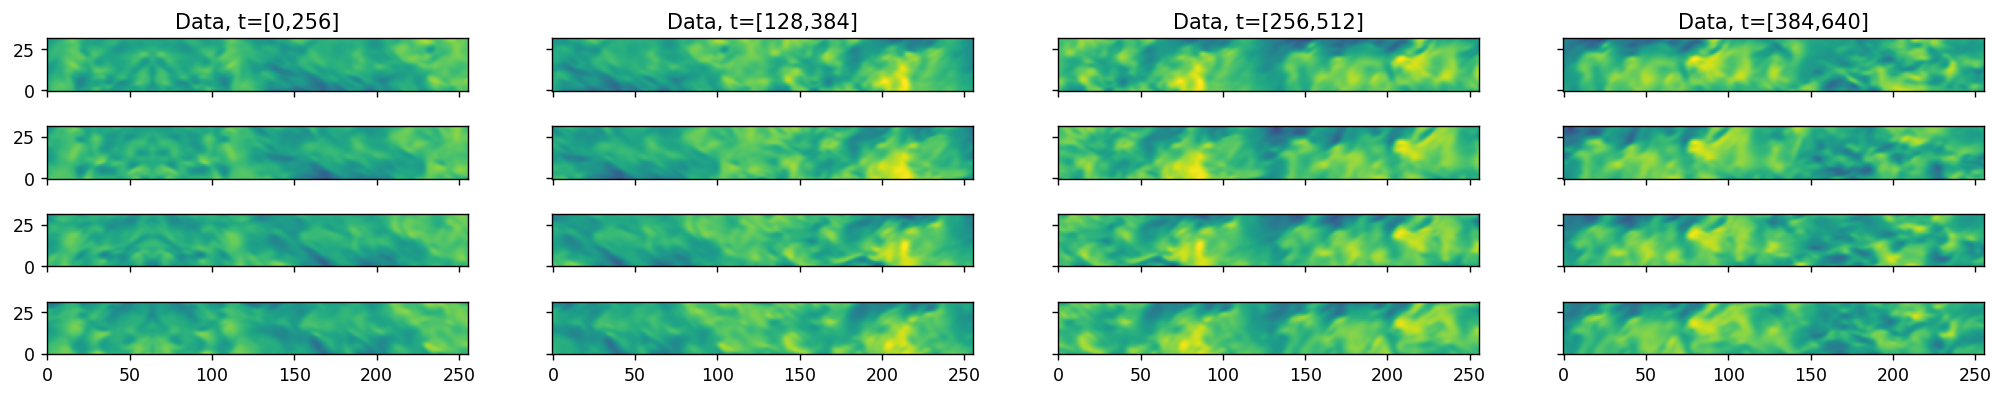

In [10]:
### Verify that the saved out conditioning data looks good
n_files_plt = 4

### Top-down view: Visualize chunked data
fig, ax = plt.subplots(n_files_plt, 4, figsize=(20,3.5), sharex=True, sharey=True, dpi=125)

dir0 = Path(out_chunk_dir.parent, 'reconstruction00')
dir1 = Path(out_chunk_dir.parent, 'reconstruction01')
dir2 = Path(out_chunk_dir.parent, 'reconstruction02')
dir3 = Path(out_chunk_dir.parent, 'reconstruction03')


for i, curr_dirr in enumerate([dir0, dir1, dir2, dir3]):
    ## Load data
    viz_data0 = np.load(Path(curr_dirr, 'data_chunk0000.npy'))
    viz_data1 = np.load(Path(curr_dirr, 'data_chunk0001.npy'))
    viz_data2 = np.load(Path(curr_dirr, 'data_chunk0002.npy'))
    viz_data3 = np.load(Path(curr_dirr, 'data_chunk0003.npy'))

    # ## Decorate
    # ax[0].set_ylabel('y index')
    # ax[0].set_xlabel('Time index')
    # ax[1].set_xlabel('Time index')
    # ax[2].set_xlabel('Time index')


    ## Plot
    ichan = 0
    ax[i,0].imshow(viz_data0[ichan,:,:,klo_in_rel].T,
                 origin='lower',
                 vmin=pltmin,
                 vmax=pltmax)
    ax[i,1].imshow(viz_data1[ichan,:,:,klo_in_rel].T,
                 origin='lower',
                 vmin=pltmin,
                 vmax=pltmax)
    ax[i,2].imshow(viz_data2[ichan,:,:,klo_in_rel].T,
                 origin='lower',
                 vmin=pltmin,
                 vmax=pltmax)
    ax[i,3].imshow(viz_data3[ichan,:,:,klo_in_rel].T,
                 origin='lower',
                 vmin=pltmin,
                 vmax=pltmax)

ax[0,0].set_title("Data, t=[0,256]")
ax[0,1].set_title("Data, t=[128,384]")
ax[0,2].set_title("Data, t=[256,512]")
ax[0,3].set_title("Data, t=[384,640]")
    
plt.show()

In [11]:
640+128-704

64

In [12]:
out_chunk_dir

PosixPath('/projects/wakedynamics/orybchuk/bcs-ldm/palette/execute_sampling/processed_data/240606/y11520/reconstruction31')